## Ingest images
Images of each deer are roughly square, and stored in a local folder. The images are ingested via `glob` and files that do not contain year information is removed. Once ingested, resized, and stacked, the labels are extracted from each images based on their filename.

In [1]:
from glob import glob
from generic.analysis.basics import extract_labels
from generic.analysis.basics import ingest_resize_stack

# Find/ingest files in folder; force square & b/w
files = glob("..\\images\\squared\\*.png")
files = [s for s in files if "xpx" not in s]
print(len(files), "images found")

# Ingest images
images = ingest_resize_stack(files)
_,_,_,ages,_ = extract_labels(files)
print('Sample size:', images.shape)

40 images found
Sample size: (40, 288, 288)


## Split datasets
The image stack is then split into training and test data, with a split of 80/20 -- 80% of the data resides in the training set, while the remaining 20% defines the test data. The training and test data are then normalized, and the labels for each dataset are cast to categorical values instead of their age values.

The validation data is then extracted from the training dataset, again in an 80/20 split -- 80% of the previous training data remains within the training dataset, and 20% is redefined as the validation set. Each dataset (training, validation, and test) are reshaped based on their format of grayscale images.

In [2]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split

# Create a mapping that combines 5.5+ years into a single "mature" class
ages_array = np.array(ages)
mature_ages = []

for i, age in enumerate(ages_array):
    if age >= 5.5:
        ages_array[i] = 5.5  # Set all ages 5.5+ to 5.5
        if age not in mature_ages:
            mature_ages.append(age)

print(f"Merged these ages into the 'mature' (5.5+) class: {mature_ages}")

# Now create your label mapping with the modified ages
label_mapping = {label: i for i, label in enumerate(np.unique(ages_array))}
print("New label mapping:", label_mapping)

# Apply the mapping to convert labels to integers
integer_labels = np.array([label_mapping[l] for l in ages_array])

# First, do a regular split for the test set (remove stratification)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, integer_labels, 
    test_size=0.2, 
    random_state=42
    # Removed stratify parameter
)

# Check the class distribution in training+validation set
print("\nClass distribution after first split:")
for label in np.unique(y_train_val):
    count = np.sum(y_train_val == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

# One-hot encode labels AFTER splitting but BEFORE the next split
num_classes = len(label_mapping)
y_train_val_onehot = keras.utils.to_categorical(y_train_val, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Normalize and reshape images
X_train_val = X_train_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
X_train_val = X_train_val.reshape(X_train_val.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

# Second split without stratification for validation
X_train_orig, X_valid, y_train_orig, y_valid = train_test_split(
    X_train_val, 
    y_train_val_onehot, 
    test_size=0.2, 
    random_state=42
    # Removed stratify parameter
)

# Print the class distribution to check
print("\nTraining set class distribution (after both splits):")
train_class_dist = np.argmax(y_train_orig, axis=1)
for label in np.unique(train_class_dist):
    count = np.sum(train_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

print("\nValidation set class distribution:")
valid_class_dist = np.argmax(y_valid, axis=1)
for label in np.unique(valid_class_dist):
    count = np.sum(valid_class_dist == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples")

Merged these ages into the 'mature' (5.5+) class: [np.float64(5.5), np.float64(12.5), np.float64(6.5)]
New label mapping: {np.float64(1.5): 0, np.float64(2.5): 1, np.float64(3.5): 2, np.float64(4.5): 3, np.float64(5.5): 4}

Class distribution after first split:
Label 0 (1.5): 3 samples
Label 1 (2.5): 9 samples
Label 2 (3.5): 8 samples
Label 3 (4.5): 3 samples
Label 4 (5.5): 9 samples

Training set class distribution (after both splits):
Label 0 (1.5): 2 samples
Label 1 (2.5): 8 samples
Label 2 (3.5): 5 samples
Label 3 (4.5): 2 samples
Label 4 (5.5): 8 samples

Validation set class distribution:
Label 0 (1.5): 1 samples
Label 1 (2.5): 1 samples
Label 2 (3.5): 3 samples
Label 3 (4.5): 1 samples
Label 4 (5.5): 1 samples


In [4]:
# After your initial train/test split, you should have X_train_val, X_test, y_train_val, y_test
# X_train_val and y_train_val are what you want to use instead of X_train and y_train

# Get the number of classes
num_classes = len(label_mapping)

# One-hot encode labels BEFORE splitting into train/validation
y_train_val_onehot = keras.utils.to_categorical(y_train_val, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Reshape data to add channel dimension
X_train_val = X_train_val.reshape(X_train_val.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

# Create a validation set (without stratification)
X_train_orig, X_valid, y_train_orig, y_valid = train_test_split(
    X_train_val, 
    y_train_val_onehot, 
    test_size=0.2, 
    random_state=42
)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Print original sizes
print("\nBefore augmentation:")
print(X_train_orig.shape[0], "train samples")
print(X_test.shape[0], "test samples")
print(X_valid.shape[0], "validation samples")

# Setup more diverse but moderate data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,              # Slightly more rotation
    width_shift_range=0.2,          # More shifting
    height_shift_range=0.2,
    zoom_range=0.2,                 # More zooming
    horizontal_flip=True,           # Horizontal flip is good
    brightness_range=[0.7, 1.3],    # More brightness variation
    shear_range=15,                 # More shearing
    fill_mode='nearest',
    # Add these new augmentations:
    channel_shift_range=0.1,        # Slight color changes
    vertical_flip=False,            # Deer won't be upside down in real images
)

# Method 2: Generate augmented data in advance
# Define how many augmented samples per original sample - reduced from 50 to 10
augmentation_factor = 10  # More reasonable multiplication factor
num_to_generate = X_train_orig.shape[0] * augmentation_factor

# Initialize empty arrays for augmented data
augmented_images = []
augmented_labels = []

# Create augmented images batch by batch
batch_size = 32
generated_count = 0

# Create a flow from the original data (without shuffling)
aug_gen = datagen.flow(
    X_train_orig, 
    y_train_orig,
    batch_size=batch_size,
    shuffle=False  # Important: keep the same order as labels
)

while generated_count < num_to_generate:
    # Get the next batch
    x_batch, y_batch = next(aug_gen)
    
    # Add to our collections
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    
    # Update the count
    generated_count += len(x_batch)
    
    # Break if we've generated enough
    if generated_count >= num_to_generate:
        break

# Concatenate all batches
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

# Trim excess (due to batch size)
augmented_images = augmented_images[:num_to_generate]
augmented_labels = augmented_labels[:num_to_generate]

# Combine with original data
X_train_combined = np.concatenate([X_train_orig, augmented_images])
y_train_combined = np.concatenate([y_train_orig, augmented_labels])

# Print new sizes after augmentation
print("\nAfter augmentation:")
print("Original training samples:", X_train_orig.shape[0])
print("Augmented training samples:", augmented_images.shape[0])
print("Combined training samples:", X_train_combined.shape[0])
print("Augmentation multiplier:", X_train_combined.shape[0] / X_train_orig.shape[0])
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)


Before augmentation:
25 train samples
8 test samples
7 validation samples

After augmentation:
Original training samples: 25
Augmented training samples: 250
Combined training samples: 275
Augmentation multiplier: 11.0
X_train_combined shape: (275, 288, 288, 1)
y_train_combined shape: (275, 5)


## Build network
With the data formatted and separated, we can now build the CNN.

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2

# Redefine the model with L2 regularization
model = Sequential()
# Start with fewer filters
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu', input_shape=(288, 288, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# Global pooling instead of more conv layers
model.add(GlobalAveragePooling2D())
# Single dense layer with higher dropout
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))  # Higher dropout to prevent overfitting
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile with a lower learning rate
from keras.optimizers import RMSprop
model.compile(
    loss='categorical_crossentropy', 
    optimizer=RMSprop(learning_rate=0.0001), 
    metrics=['accuracy']
)

G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 288, 288, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 144, 144, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 144, 144, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 36, 36, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,709 (252.77 KB)

 Trainable params: 64,709 (252.77 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Calculate class weights properly based on the class distribution
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract the class labels from one-hot encoded y_train_orig
y_integers = np.argmax(y_train_orig, axis=1)

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# Convert to dictionary format for Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weight_dict)

# Now train the model with properly calculated class weights
checkpointer = ModelCheckpoint(
    filepath='model_augmented.weights.best.hdf5.keras',
    verbose=1, 
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Give it more time to learn with class weights
    restore_best_weights=True,
    verbose=1
)

print("\nTraining with class weights:")
hist_augmented = model.fit(
    X_train_combined, 
    y_train_combined,
    batch_size=16,
    epochs=100,  # Increase epochs to give more training time
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer, early_stopping],
    verbose=1,
    shuffle=True,
    class_weight=class_weight_dict  # Use the properly calculated weights
)

Class weights: {0: np.float64(2.5), 1: np.float64(0.625), 2: np.float64(1.0), 3: np.float64(2.5), 4: np.float64(0.625)}

Training with class weights:
Epoch 1/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2577 - loss: 1.7458
Epoch 1: val_loss improved from inf to 1.79642, saving model to model_augmented.weights.best.hdf5.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.2627 - loss: 1.7514 - val_accuracy: 0.1429 - val_loss: 1.7964
Epoch 2/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2109 - loss: 1.7016
Epoch 2: val_loss improved from 1.79642 to 1.79257, saving model to model_augmented.weights.best.hdf5.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2128 - loss: 1.7114 - val_accuracy: 0.1429 - val_loss: 1.7926
Epoch 3/100
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2347 - loss: 1.8400
Epoch 3: val_loss improved from 1.79257 to 1.78912, saving model to model_augmented.weights.best.hdf5.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms

Comprehensive Class Evaluation:
 Class Index  Original Label  In Test Set  In Predictions  Precision  Recall  F1 Score
           0             1.5         True           False        NaN     NaN       NaN
           1             2.5         True            True      0.375     1.0  0.545455
           2             3.5         True           False        NaN     NaN       NaN
           3             4.5         True           False        NaN     NaN       NaN
           4             5.5         True           False        NaN     NaN       NaN


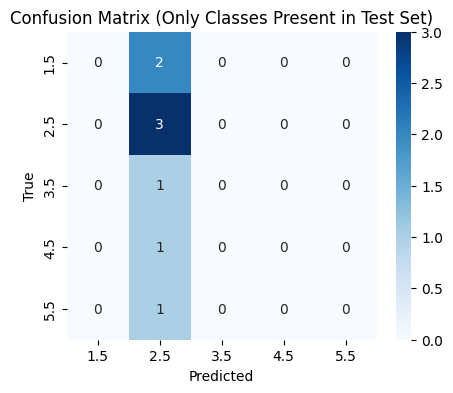


Overall Test Accuracy: 0.3750


In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Evaluate with the best weights
model.load_weights('model_augmented.weights.best.hdf5.keras')

# Create a reverse mapping to get original labels
reverse_mapping = {i: label for label, i in label_mapping.items()}

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Create a comprehensive evaluation table that includes all classes
all_classes = list(range(num_classes))
all_class_names = [reverse_mapping[i] for i in all_classes]

# Create a comprehensive DataFrame
results_df = pd.DataFrame({
    'Class Index': all_classes,
    'Original Label': all_class_names,
    'In Test Set': [i in y_true for i in all_classes],
    'In Predictions': [i in y_pred for i in all_classes]
})

# Add metrics where applicable
precision_values = []
recall_values = []
f1_values = []
for cls in all_classes:
    if cls in y_true and cls in y_pred:
        # We can calculate metrics for this class
        true_binary = (y_true == cls).astype(int)
        pred_binary = (y_pred == cls).astype(int)
        precision_values.append(precision_score(true_binary, pred_binary, zero_division=0))
        recall_values.append(recall_score(true_binary, pred_binary, zero_division=0))
        f1_values.append(f1_score(true_binary, pred_binary, zero_division=0))
    else:
        # Class not present in test set or predictions
        precision_values.append(float('nan'))
        recall_values.append(float('nan'))
        f1_values.append(float('nan'))

results_df['Precision'] = precision_values
results_df['Recall'] = recall_values
results_df['F1 Score'] = f1_values

print("Comprehensive Class Evaluation:")
print(results_df.to_string(index=False))

# Create a confusion matrix (will only show classes present in test set)
cm = confusion_matrix(y_true, y_pred)
present_classes = sorted(set(np.concatenate([y_true, y_pred])))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]}" for i in present_classes],
           yticklabels=[f"{reverse_mapping[i]}" for i in present_classes])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Only Classes Present in Test Set)')
plt.show()

# Show overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"\nOverall Test Accuracy: {accuracy:.4f}")